In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from utils_notebook import modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized

In [2]:
DATASET = 'imdb'
# DATASET = 'ag'

In [3]:
logits = torch.load(f'outputs/{DATASET}_logits.pt', map_location=torch.device('cpu'))
targets = torch.load(f'outputs/{DATASET}_targets.pt', map_location=torch.device('cpu'))

In [4]:
L = logits.shape[0]
N = logits.shape[1]
C = logits.shape[2]

logits.shape, targets.shape

(torch.Size([4, 25000, 2]), torch.Size([25000]))

In [5]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [6]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [7]:
torch.isnan(probs_poe_ovr_break_ties_generalized).any()

tensor(False)

In [8]:
[round(float(x), 4) for x in acc]

[0.8282, 0.8698, 0.8862, 0.9008]

In [9]:
modal_probs_decreasing(preds, probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5, -0.75], diffs_type='all')

{0.0001: 54.748,
 0.01: 40.88,
 0.05: 25.679999999999996,
 0.1: 16.904,
 0.2: 8.155999999999999,
 0.25: 5.476,
 0.33: 2.572,
 0.5: 0.464,
 0.75: 0.004}

In [10]:

[round(float(x), 4) for x in acc_poe_ovr_break_ties_generalized]

[0.8282, 0.8699, 0.8864, 0.901]

In [11]:
modal_probs_decreasing(preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 
                                             L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5, -0.75], diffs_type='all', verbose=True)

20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
20 [1.         1.         0.36736506 0.7558349 ]
22 [0.         0.8504216  0.9606788  0.92108697]
22 [0.         0.8504216  0.9606788  0.92108697]
54 [1.         1.         1.         0.52486134]
54 [1.         1.         1.         0.52486134]
54 [1.         1.         1.         0.52486134]
54 [1.         1.         1.         0.52486134]
54 [1.         1.         1.         0.52486134]
54 [1.         1.         1.         0.52486134]
54 [1.         1.         1.         0.52486134]
69 [1.         1.         0.3988433  0.70325625]
69 [1.         1.         0.3988433  0.70325625]
69 [1.         1.         0.3988433  0.70325625]
69 [1.         1.   

{0.0001: 7.672,
 0.01: 7.4399999999999995,
 0.05: 6.644,
 0.1: 6.016,
 0.2: 5.28,
 0.25: 5.092,
 0.33: 4.812,
 0.5: 3.3320000000000003,
 0.75: 0.28400000000000003}

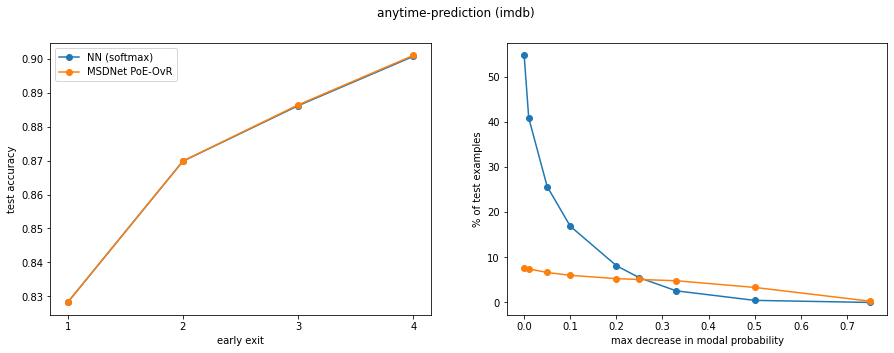

In [12]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='MSDNet PoE-OvR', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')
ax[0].set_xticks(early_exits)

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'MSDNet PoE-OvR'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5, -0.75], diffs_type='all')
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({DATASET})')
plt.show()

In [13]:
zero_prob_ids = []
for n in range(N):
    if torch.max((logits[:, n, :] > 0).sum(axis=0)) != L:
        zero_prob_ids.append(n)

In [14]:
len(zero_prob_ids) / N

0.13884

In [15]:
i = 0
logits[:, i, :], probs_poe_ovr_break_ties_generalized[:, i, :]

(tensor([[-0.1536,  0.6087],
         [ 0.3132, -0.3135],
         [ 0.7611, -0.6028],
         [ 0.7949, -0.7246]]),
 tensor([[0.0000, 1.0000],
         [0.6518, 0.3482],
         [0.7964, 0.2036],
         [0.8205, 0.1795]]))

In [16]:
i = 34
print("id: ", i, " modal-prob id: ", int(preds_poe_ovr_break_ties_generalized[L - 1][i]))
# for l in range(L):
#     print(f'early exit {l + 1}')
#     print(logits[l, i, :])
#     print(probs_poe_ovr_break_ties_generalized[l, i, :])
#     print('\n')
print(f'===============LOGITS=================')
print(logits[:, i, :])
print(f'===============PoE-OvR probs=================')
print(probs_poe_ovr_break_ties_generalized[:, i, :])


id:  34  modal-prob id:  1
===============LOGITS=================
tensor([[ 0.5439, -0.0812],
        [-0.2033,  0.2257],
        [-0.2366,  0.2049],
        [-0.7866,  1.0103]])
===============PoE-OvR probs=================
tensor([[1.0000, 0.0000],
        [0.3944, 0.6056],
        [0.3914, 0.6086],
        [0.1422, 0.8578]])


In [17]:
# fig, ax = plt.subplots(L, 2, figsize=(5, 15), sharey=True)
# for l in range(L):
#     ax[l, 0].bar(np.arange(1, C + 1, 1), logits[l, i, :].numpy())
#     ax[l, 1].bar(np.arange(1, C + 1, 1), probs_poe_ovr_break_ties_generalized[l, i, :].numpy())
# plt.show()